## Introduction

Welcome to this Julia Jupyter notebook where we will present some likelihood-free inference methods! 

The methods that will be covered are: Approximate Bayesian Computing (ABC) rejection sampling, ABC Markov chain Monte Carlo (MCMC), particle Markov chain Monte Carlo. We will for each method present a hands-on case study where the method is used to solve some statistical inference problem.   

A self-containing introduction to Bayesian inference and the standard Metropolis-Hastings algorithm is provided in this notebook in Section [1](#sec_intro). However, a reader already familiar with these topics can without loss of information skip this introduction.   
 
#### About this notebook

The notebook was originally created as a part of the course *Reproducible and Interactive Data Science* ([course homepage](https://github.com/mlund/jupyter-course)). The author of this notebook is Samuel Wiqvist, Ph.D. student in mathematical statistics at Lund University ([homepage](http://www.maths.lu.se/staff/samuel-wiqvist/), [Twitter](https://www.twitter.com/samuel_wiqvist)). If you have any comments or question, please feel free to contact me via mail or on Twitter. 


# Table of contents
1. [Bayesain inference using the Metropolis-Hastings algorithm](#sec_intro)
    1. [Case study - Bayesian linear regression](#subsec_intro)        

2. [Likelihood-free inference](#sec_lik_free_inference)

3. [ABC method](#secabc)
    1. [ABC rejection sampling](#subsecabc1) 
        1. [Case study - g-and-k distribution](#subsecabc1_case)        
    1. [ABC MCMC](#subsecabc2)
        1. [Case study - g-and-k distribtuion, again](#subsubsecabc2_case)        
            1. [Excat Bayesian inference for the g-and-k distribtuion](#subsubsecabc2_case)        
            2. [Comparing inference results for the g-and-k distribtuion](#subsubsecabc2_case)        
4. [Conclusions](#sec_conclusions)



## Bayesian inference using the Metropolis-Hastings algorithm  <a name="sec_intro"></a>

We will here consider the Bayesian inference problem where the main goal is to compute the *parameter* posterior $\pi(\theta | y)$. A Bayesian model in our setting consists of three parts: the prior $\pi(\theta)$, the likelihood $\pi(y | \theta)$, and the posterior $\pi(\theta | y)$. The prior $\pi(\theta)$ is the probability model for the parameters that we have *before* we have *seen* the data and those incorporates our prior beliefs about the parameters. The likelihood $\pi(y | \theta)$ is the probability model for the data $y$ *give* the parameters, and in the standard case is this model known analytically. The posterior $\pi(\theta | y)$ is the probability model for the parameters *give* data, and the main task in the Bayesian inference scheme is to compute (usually using some numerical method) this distribution. 

Using Bayes rule, we have that 

\begin{align*}
p(\theta | y) = \frac{p(y | \theta) p(\theta)}{p(y)} = \frac{p(y | \theta) p(\theta)}{\int_{}^{} p(y | \theta) p(\theta) d\theta}.
\end{align*}

Hence, the Bayesian inference problem *can* easily be solved by simply applying Bayes rule. This, however, only works for simple problems where the integral $\int_{}^{} p(y | \theta) p(\theta) d\theta$ can be computed, our in cases where the functional form of the posterior is known analytically. In practice is the  integral $\int_{}^{} p(y | \theta) p(\theta) d\theta$  often hard  to compute, or analytical intractable. However, the integral $\int_{}^{} p(y | \theta) p(\theta) d\theta$  is the normalizing constant, and if this constant is not included we have 

\begin{align*}
p(\theta | y) \propto p(y | \theta) p(\theta).
\end{align*}

This is an important property for the posterior distribution since the normalizing constant is unimportant in many algorithms, and this property allows us to compute the posterior distribution up to a normalizing constant. For a more detailed introduction see [ [4]](#ref_1) for an overview of the literature, and [ [5]](#ref_2) for an excellent explanation of the rule of the prior distribution. 

We will now consider the Metropolis-Hastings (MH) algorithm which is a Markov chain Monte Carlo method. The main idea of a Markov chain Monte Carlo method is to construct a Markov chain that has the posterior distribution as its stationary distribution. The MH algorithm obtains this goal by generating proposals $\theta^{\star}$ from a proposal distribution $g(\cdot|\theta^{i-1})$, the proposals are then accepted in such a manner that the stationary distribution of chain (under some regulatory conditions) is the posterior distribution (see [ [3]](#ref_3) for an accessible introduction to the MH algorithm). The pseudo-code for the MH algorithm is 

At iteration $i$: 
1. Generate proposal $\theta^{\star} \sim g(\cdot|\theta^{i-1})$.
2. Compute accaptance probability $\alpha = \min(1, \frac{p(y|\theta^{\star})p(\theta^{\star})g(\theta^{i-1}|\theta^{\star})}{p(y|\theta^{i-1})p(\theta^{i-1})g(\theta^{\star}|\theta^{i-1})})$.
3. Draw $u \sim \mathcal{U}(0,1)$.
4. If $u \leq \alpha$ accepte the proposal, and add it the chain, else reject the proposal, and keep the old $\theta^{t-1}$.

An important property of the MH algorithm is the proposal distribution $g(\cdot|\theta^{i-1})$. A common case is to use a Gaussian distribution for the proposal distribution such that we have that $g(\cdot|\theta^{i-1}) \sim \mathcal{N}(\theta^{i-1}, \sigma)$. However, selecting the standard deviation $\sigma$ now plays an important role since  $\sigma$  will have a large impact on the performance of the algorithm. If $\sigma$ is too small will the acceptance rate be very high, but the algorithm will not efficiently explore the parameter space. On the other hand, if $\sigma$ is too high will the acceptance rate be too low, and the chain will mix slowly. 

Another popular choice is to adaptively tune the proposal distribution and thereby avoiding the problem of setting the $\sigma$ parameter in the proposal distribution. For further reading on adaptively tune the proposal distribution see  [ [6]](#ref_4), [ [2]](#ref_5), and [ [8]](#ref_6).

### Case study - Bayesian linear regression <a name="subsec_intro"></a>

The simple linear regression model is a commonly used model in statistics, and the model follows 

\begin{align*}
y_i = \beta_0 + \beta_1 x_i + \epsilon_i, \, \epsilon_i \sim \mathcal{N}(0, \sigma). 
\end{align*}

The unknown parameters of interstes are $\theta = [\beta_0, \beta_1, \sigma]$, and we will set the ground-truth parameters to $\theta_{\text{true}} = [1.2, 1.5, 2]$. 

This model can also be considered in a Bayesian setting by adding prior distributions to the unknown parameters, and we then have following model 

\begin{align*}
y_i &= \beta_0 + \beta_1 x_i + \epsilon_i, \, \epsilon_i \sim \mathcal{N}(0, \sigma), \\
\beta_0, \beta_1 &\sim \mathcal{N}(0, 10), \\
\sigma &\sim \text{Gamma}(2,3).
\end{align*}

The prior distribution for the $\beta$ parameters is a Normal distribution with mean 0 and standard deviation 10. Hence, this prior is a wide distribution centered at zero that allows for both positive and negative $\beta$'s. The prior distribution for $\sigma$ is a Gamma distribution with shape parameter 2, and scale parameter 3. This is also a quite conservative prior, but the prior does not support negative values since $\sigma$ must be positive.

We will now estimate the parameter for the simple linear regression model using standard least squares estimation methods, and we will for the Bayesian version of the model use the MH algorithm.


Load packages. 

In [1]:
using PyPlot # for plotting
using Distributions # function for variuse distributions 
using StatsBase # simple stats functions 
using KernelDensity # kernel density estimation 
using DataFrames # dataframe functionalities 

Load data generated from the model using the ground-truth parameters. 

In [2]:
# set model parameters
β_0 = 1.2;
β_1 = 1.5;
σ = 2;
θ_true = [β_0, β_1, σ];

# load data 
lin_red_data = readtable("data/lin_reg_data.csv");
x = vec(Array(lin_red_data[1,:]));
y = vec(Array(lin_red_data[2,:]));

# set nbr data points 
n = length(x);


Plot data. 

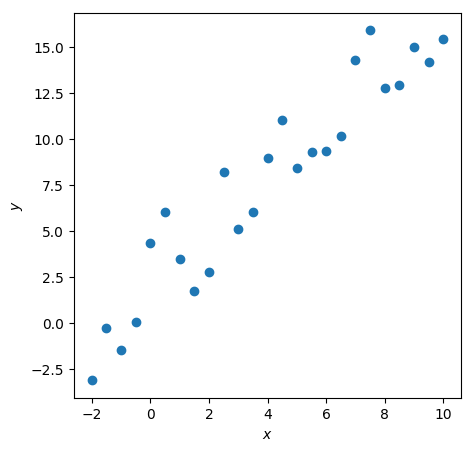

In [3]:
PyPlot.figure(figsize=(5,5));
PyPlot.scatter(x,y);
PyPlot.xlabel(L"$x$");
PyPlot.ylabel(L"$y$");

Before estimating the unknown parameters for the Bayesian model, we estimate parameters for the simple linear regression model using least squares. 

In [4]:
# least squares parameter estimation
n = length(y)

X = ones(n,2); # set desing matrix 
X[:,2] = x;

β_hat_least_squares = inv(X'*X)*X'*y;
σ_hat_least_squares = sqrt((y'*y-β_hat_least_squares'*X'*y)/(n-2));
β_hat_least_squares_std = σ_hat_least_squares*sqrt.(diag(inv(X'*X)));
conf_int_lower_bound = round.(β_hat_least_squares - quantile(TDist(n-2), 0.975)*β_hat_least_squares_std,3);
conf_int_upper_bound = round.(β_hat_least_squares + quantile(TDist(n-2), 0.975)*β_hat_least_squares_std,3);

Parameter estimations. 

In [6]:
df_ls_param_est = DataFrame(parameter = ["β_0"; "β_1";"σ"], true_values = θ_true, param_est = round.([β_hat_least_squares;σ_hat_least_squares],3))

,parameter,true_values,param_est
1,β_0,1.2,1.791
2,β_1,1.5,1.459
3,σ,2.0,1.85


Parameter estimation uncertainties (95% confidence interval). 

In [7]:
df_ls_param_est_unc = DataFrame(parameter = ["β_0"; "β_1";"σ"], conf_int = ["($(conf_int_lower_bound[1]), $(conf_int_upper_bound[1]))"; "($(conf_int_lower_bound[2]), $(conf_int_upper_bound[2]))"; "NA"])


,parameter,conf_int
1,β_0,"(0.648, 2.934)"
2,β_1,"(1.246, 1.671)"
3,σ,NA


We now continue to the Bayesian model, and we first set the parameters for the prior distributions.

In [8]:
# prior for β's: Normal(0,10)
μ_β_prior = 0;
σ_β_prior = 10;

# prior for σ: Gamma(2,3)
α_σ_prior = 2; # shape parameter
θ_σ_prior = 3; # scale parameter

The next step is to set up some functions needed for the MH algorithm. 

Function to evaluate the joint log-prior. 

In [9]:
doc"""
    log_prior(θ::Vector)

Evaluates the logarithm of the pdf for the joint prior.
"""
function log_prior(θ::Vector)

  log_β_0_prior = log_normal_pdf(θ[1])
  log_β_1_prior = log_normal_pdf(θ[2])
  log_σ_prior = log_gamma_pdf(θ[3])

  return log_β_0_prior+log_β_1_prior+log_σ_prior

end

log_prior

Logarithm of probability density function for the Normal distribution. Notice that the normalizing constant, and the term that only depends on $\sigma$ in the Normal distribution, are removed since these terms do not depend on the $\theta$ proposals in the MH algorithm.

In [10]:

doc"""
    log_normal_pdf(x::Real)

Logarithm of the normal pdf.
"""
function log_normal_pdf(x::Real)
  return -0.5*(x-μ_β_prior)^2/σ_β_prior^2

end

log_normal_pdf

Logarithm of probability density function for the Gamma distribution. We again remove unnecessary constants, and we also set the likelihood to zero is $x$ is less than zero since the Gamma distribution only supports positive $x$ values. 

In [11]:
doc"""
    log_gamma_pdf(x::Real)

Logarithm of the Gamma pdf.
"""
function log_gamma_pdf(x::Real)
  if x < 0
    return log(0)
  else
    return (α_σ_prior-1)*log(x)-x/θ_σ_prior
  end
end

log_gamma_pdf

Since we assume Gaussian noise in the simple linear model, we have that the likelihood of the simple linear model can be written as

\begin{align*}
p(y | \theta) = \prod_{i =1}^{N} \frac{1}{\sqrt{2\pi\sigma^2}}\exp\Big(-\frac{(y_i - \beta_0 - \beta_1 x_i)^2}{2\sigma^2}\Big).
\end{align*}

Where we have that $\theta = [\beta_0, \beta_ 1, \sigma]$. Now taking the logarithm of the likelihood yields

\begin{align*}
\log p(y | \theta) = \sum_{i =1}^{N}  -\frac{1}{2}\log(2\pi) -\frac{1}{2}\log(\sigma^2) -\frac{(y_i - \beta_0 - \beta_1 x_i)^2}{2\sigma^2}.
\end{align*}


Hence, after removing constants, we can compute the log-likelihood using the function ```loglik```.

In [12]:
doc"""
    loglik(y::Vector, x::Vector, θ::Vector)

Log-likelihood for the simple linear model.
"""
function loglik(y::Vector, x::Vector, θ::Vector)

  n = length(y)
  loglik = -n*0.5*log(θ[3]^2)

  for i = 1:n
    loglik += -0.5*(y[i]-θ[1]-θ[2]*x[i])^2/θ[3]^2
  end

  return loglik

end

loglik

The Metropolis-Hastings algorithm. Notice that we compute the acceptance probability on the log-scale and that a random walk proposal with fixed scaling is used. 

In [13]:

doc"""
    MH(y::Vector, x::Vector, nbr_iter::Int, σ_mh::Real, θ_0::Vector, print_interval::Int=500)

Runs the Metropolis-Hastings algorithm.
"""
function MH(y::Vector, x::Vector, nbr_iter::Int, σ_mh::Real, θ_0::Vector, print_interval::Int=500)

  # pre-allocate matrices
  chain = zeros(length(θ_0), nbr_iter)
  loglik_vec = zeros(nbr_iter)
  accept_vec = zeros(nbr_iter)

  # set start values
  chain[:,1] = θ_0
  loglik_vec[1] = loglik(y,x,chain[:,1])

  # print start
  @printf "Starting Metropolis–Hastings\n"



  for i = 2:nbr_iter

    # print info
    if mod(i-1,print_interval) == 0
      # print progress
      @printf "Percentage done: %.2f\n" 100*(i-1)/nbr_iter
      # print current acceptance rate
      @printf "Acceptance rate on iteration %d to %d is %.4f\n" i-print_interval i-1  sum(accept_vec[i-print_interval:i-1])/( i-1 - (i-print_interval) )
    end

    # random walk proposal
    θ_proposal = chain[:,i-1] + rand(Normal(0,1),length(θ_0))*σ_mh

    # loglik for proposal
    loglik_proposal = loglik(y,x,θ_proposal)

    # compute logarithm of accaptance probability
    α_log = loglik_proposal + log_prior(θ_proposal) - (loglik(y,x,chain[:,i-1])+ log_prior(chain[:,i-1]))

    # generate log random number
    u_log = log(rand())

    # compute accaptance decision
    accept = u_log < α_log

    # update chain
    if accept
      chain[:,i] = θ_proposal
      loglik_vec[i] = loglik_proposal
      accept_vec[i] = 1
    else
      chain[:,i] = chain[:,i-1]
      loglik_vec[i] = loglik_vec[i-1]
    end

  end

  # print info
  @printf "Ending Metropolis–Hastings\n"
  return chain, loglik_vec, accept_vec

end

MH

Estimate parameters for the Bayesian version of the simple linear regression model. 

In [14]:
nbr_iter = 10000; # nbr iterations 
burn_in = 2000; # burn-in
scale_proposal = 0.4; # scaling for proposal dist. 
θ_0 = [10,10,10]; # start values 

# fix random numbers 
srand(100);

chain, loglik_vec, accept_vec = @time MH(y, x, nbr_iter, scale_proposal, θ_0);


Starting Metropolis–Hastings
Percentage done: 5.00
Acceptance rate on iteration 1 to 500 is 0.3367
Percentage done: 10.00
Acceptance rate on iteration 501 to 1000 is 0.1563
Percentage done: 15.00
Acceptance rate on iteration 1001 to 1500 is 0.1062
Percentage done: 20.00
Acceptance rate on iteration 1501 to 2000 is 0.2064
Percentage done: 25.00
Acceptance rate on iteration 2001 to 2500 is 0.1303
Percentage done: 30.00
Acceptance rate on iteration 2501 to 3000 is 0.1283
Percentage done: 35.00
Acceptance rate on iteration 3001 to 3500 is 0.1563
Percentage done: 40.00
Acceptance rate on iteration 3501 to 4000 is 0.1383
Percentage done: 45.00
Acceptance rate on iteration 4001 to 4500 is 0.1202
Percentage done: 50.00
Acceptance rate on iteration 4501 to 5000 is 0.1303
Percentage done: 55.00
Acceptance rate on iteration 5001 to 5500 is 0.1663
Percentage done: 60.00
Acceptance rate on iteration 5501 to 6000 is 0.1583
Percentage done: 65.00
Acceptance rate on iteration 6001 to 6500 is 0.1343
Pe

Set posterior samples, i.e., chain after burn-in. 

In [15]:
posterior_samples = chain[:,burn_in:end]

3×8001 Array{Float64,2}:
 2.09103  2.09103  2.49238  2.49238  …  2.21726  2.21726  2.21726  2.21726
 1.45582  1.45582  1.43895  1.43895     1.50982  1.50982  1.50982  1.50982
 1.9666   1.9666   1.63706  1.63706     1.96168  1.96168  1.96168  1.96168

Parameter estimations (posterior mean). 

In [16]:
# calc posterior mean 
post_mean_mh = mean(posterior_samples,2)

# create data frame 
df_mh_param_est = DataFrame(parameter = ["β_0"; "β_1";"σ"], true_values = θ_true, post_mean = round.(post_mean_mh[:],3))

,parameter,true_values,post_mean
1,β_0,1.2,1.789
2,β_1,1.5,1.455
3,σ,2.0,2.004


Parameter uncertenty (posterior quantile interval, 2.5th and 97.5th quantile).

In [17]:
# calc posterior quantiles 
q = round.([quantile(posterior_samples[1,:], [0.025 0.975])
            quantile(posterior_samples[2,:], [0.025 0.975])
            quantile(posterior_samples[3,:], [0.025 0.975])],3)

# create data frame 
df_mh_param_est_unc = DataFrame(parameter = ["β_0"; "β_1";"σ"], true_values = θ_true, quant_int =   ["($(q[1,1]), $(q[1,2]))"; "($(q[2,1]), $(q[2,2]))"; "($(q[3,1]), $(q[3,2]))"])

,parameter,true_values,quant_int
1,β_0,1.2,"(0.595, 3.025)"
2,β_1,1.5,"(1.221, 1.691)"
3,σ,2.0,"(1.509, 2.72)"


Plot entire chain. 

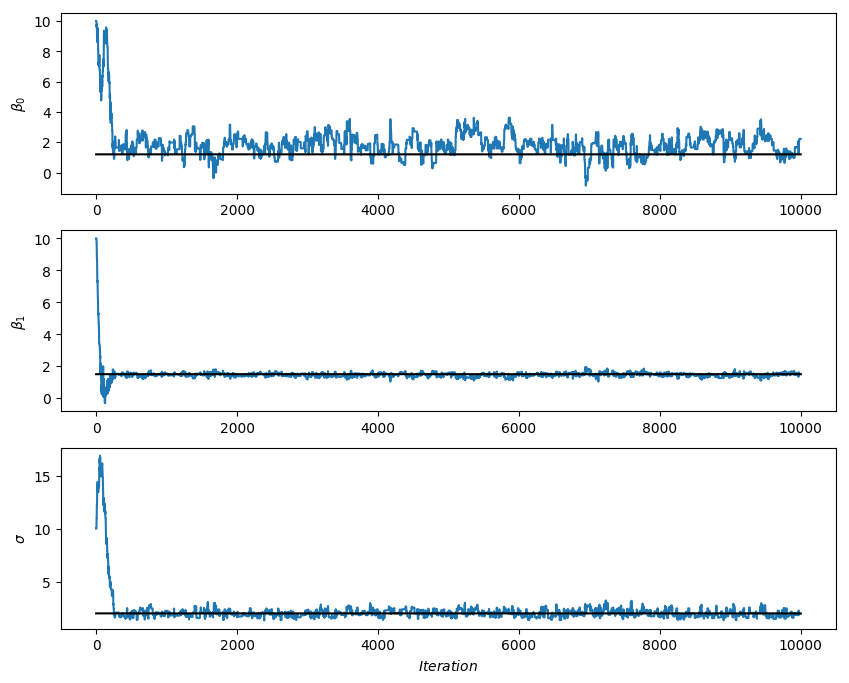

In [18]:
PyPlot.figure(figsize=(10,8));
PyPlot.subplot(311);
PyPlot.plot(chain[1,:]);
PyPlot.plot(ones(size(chain,2),1)*θ_true[1], "k");
PyPlot.ylabel(L"$β_0$");
PyPlot.subplot(312);
PyPlot.plot(chain[2,:]);
PyPlot.plot(ones(size(chain,2),1)*θ_true[2], "k");
PyPlot.ylabel(L"$β_1$");
PyPlot.subplot(313);
PyPlot.plot(chain[3,:]);
PyPlot.plot(ones(size(chain,2),1)*θ_true[3], "k");
PyPlot.xlabel(L"Iteration");
PyPlot.ylabel(L"$σ$");

Plot posterior distribution. The marginal posteriors follow the blue lines, the prior distributions follow the green linea, and the true parameter values are indicated with the black vertical lines.  

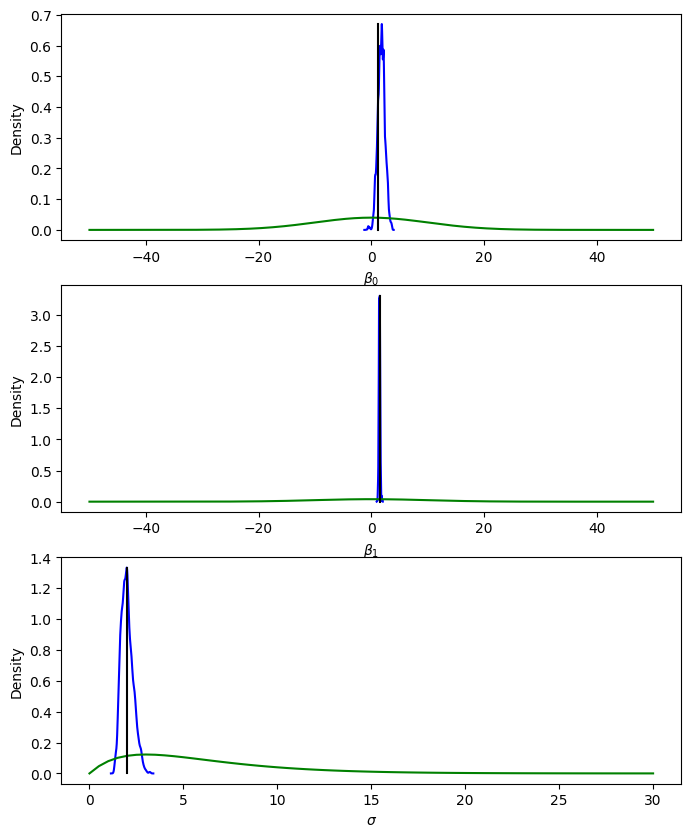

In [19]:
# calc grid for prior dist
x_c1 = -50:0.5:50;
x_c2 = -50:0.5:50;
x_c3 = 0:0.5:30;

# calc prior dist
priordens_c1 = pdf.(Normal(μ_β_prior, σ_β_prior), x_c1);
priordens_c2 = pdf.(Normal(μ_β_prior, σ_β_prior), x_c2);
priordens_c3 = pdf.(Gamma(α_σ_prior, θ_σ_prior), x_c3);

# calc kernel density approx. for approx. posterior
h1 = kde(posterior_samples[1,:]);
h2 = kde(posterior_samples[2,:]);
h3 = kde(posterior_samples[3,:]);


PyPlot.figure(figsize=(8,10));
subplot(311);
PyPlot.plot(h1.x,h1.density, "b");
PyPlot.plot(x_c1,priordens_c1, "g");
PyPlot.plot((θ_true[1], θ_true[1]), (0, maximum(h1.density)), "k");
PyPlot.xlabel(L"$β_0$");
PyPlot.ylabel("Density");
subplot(312);
PyPlot.plot(h2.x,h2.density, "b");
PyPlot.plot(x_c2,priordens_c2, "g");
PyPlot.plot((θ_true[2], θ_true[2]), (0, maximum(h2.density)), "k");
PyPlot.xlabel(L"$β_1$");
PyPlot.ylabel("Density");
subplot(313);
PyPlot.plot(h3.x,h3.density, "b");
PyPlot.plot(x_c3,priordens_c3, "g");
PyPlot.plot((θ_true[3], θ_true[3]), (0, maximum(h3.density)), "k");
PyPlot.xlabel(L"$σ$");
PyPlot.ylabel("Density");

Compare parameter estimations obtained from least squares and the MH algorithm. 

In [20]:
df_param_est = DataFrame(parameter = ["β_0"; "β_1";"σ"], true_values = θ_true, least_squares = ["$(df_ls_param_est[1,3]) ($(conf_int_lower_bound[1]), $(conf_int_upper_bound[1]))"; "$(df_mh_param_est[2,3]) ($(conf_int_lower_bound[2]), $(conf_int_upper_bound[2]))"; "$(df_mh_param_est[3,3]) NA"], Metropolis_Hastings = ["$(df_mh_param_est[1,3])  ($(q[1,1]), $(q[1,2]))"; "$(df_mh_param_est[2,3]) ($(q[2,1]), $(q[2,2]))"; "$(df_mh_param_est[3,3]) ($(q[3,1]), $(q[3,2]))"])


,parameter,true_values,least_squares,Metropolis_Hastings
1,β_0,1.2,"1.791 (0.648, 2.934)","1.789 (0.595, 3.025)"
2,β_1,1.5,"1.455 (1.246, 1.671)","1.455 (1.221, 1.691)"
3,σ,2.0,2.004 NA,"2.004 (1.509, 2.72)"


We can conclude that the parameter estimates for both the linear model and the Bayesian linear model are similar. In particular we notice that both the point estimations and the intervals are similar for the $\beta$'s. However, it is not surprising that the parameter estimations difference slightly since we compare parameter estimations for two different model, and not the same model. That being said, we see that we can cast a familiar statistical model into a Bayesian version of the same model, and still obtain parameter estimates that are similar to the ones we get from a standard estimations schemes. 


## Likelihood-free inference <a name="sec_lik_free_inference"></a>

To use the standard MH algorithm is it necessary to be able to evaluate the likelihood function $p(y|\theta)$. However, for some models is the likelihood function analytically of computationally intractable, and the standard Mh algorithm can then not be used. But we can still compute the Bayesian inference if we use a likelihood-free algorithm, which is an algorithm where we do not need to evaluate the likelihood function. We will now consider the ABC method. 



## ABC method <a name="secabc"></a>


The Approximate Bayesian Computing method is an inexact inference problem, meaning that the algorithm generates an approximation of the posterior $p(y|\theta)$. However, the ABC method is still useful since it is a very general method and can be applied to all models where we can generate data from the model. The main idea of the ABC method is to generate parameter value from a proposal distribution, and keep generated parameter value that corresponds to data *similar to* the real data. A good introduction to the ABC method is [ [13]](#ref_7). 



## ABC rejection sampling  <a name="subsecabc1"></a>
The most basic ABC method is the rejection sampling method, and in the simples version of this algorithm follows 

At iteration t:
1. Generate $\theta^{star} \sim p(\theta)$.
2. Generate data set $y^{star}$ from the model using $\theta^{\star}$. 
3. Accept $\theta^{\star}$ if $y^{star} = y$. 

This algorithm will of course only work for discrete data, for long data sets will this algorithm be *very* inefficient since we require an exact data match to accept the proposal $\theta^{\star}$. Instead of requiring an exact data match we, therefore, introduce a set of summary statistics $S(y)$ that are informative for the data, and we then have following algorithm 

At iteration t
1. Generate $\theta^{star} \sim p(\theta)$.
2. Generate data set $y^{star}$ from the model using $\theta^{\star}$. 
3. Compute summery statistics $s^{\star} = S(y^{\star})$
3. Accept $\theta^{\star}$ if $\rho(s^{\star}, s) \leq \epsilon$. 

Hence, we now have a rejection sampling algorithm where we accept proposals if the distance between the summary statistics obtained using proposal and the summary statistics for the data is smaller than some bandwidth $\epsilon$. The posterior that we obtain from this algorithm is a approximate posterior such that $p(\theta | y)_{\bf{1}(\rho(s^{\star}, s) \leq \epsilon)}$.

The problem of selecting summary statistics is of importance for the performance of the ABC  method. The summary statistics should be informative for the data, and a popular method is to simply select summary statistics that capture features of the data. However, there also exist more advanced semi-automatic methods to selects the summary statistics. [ [10]](#ref_8) 

#### The ABC rejection sampling code 

We now walk through the code for the ABC rejection sampling algorithm. 

Load the adaptive tuning algorithms for the proposal distribution. 

In [22]:
include("adaptiveupdate.jl")


Use "abstract type AdaptationAlgorithm end" instead.


adaptation

Types describing the different parts of the problem: 

In [23]:
# Types describing the different parts of the problem. 

"Type for prior distribution"
type PriorDistribution
  dist::String
  prior_parameters::Array{Float64}
end

"Type for the data"
type Data
  y::Array{Float64}
end

"Pararameters for the model"
type ModelParameters
  theta_true::Array{Float64} 
  theta_known::Float64
  theta_0::Array{Float64} 
end

"type for the algorithm parameters for the ABC-MCMC algorithm"
type AlgorithmParametersABCMCMC
  R::Int64
  burn_in::Int64
  alg::String
  print_interval::Int64
  nbr_summary_stats::Int64
  eps::Vector
  start::String
  w::Vector
end

"Type for the problem (including algorithm parameters) for the PMCMC algorithm"
type ProblemABCMCMC
  data::Data
  alg_param::AlgorithmParametersABCMCMC
  model_param::ModelParameters
  adaptive_update::AdaptationAlgorithm
  prior_dist::PriorDistribution
end

"Type for the results"
type Result
  Theta_est::Array{Float64}
  accept_vec::Array{Float64}
  prior_vec::Array{Float64}
end


Result

The ABC rejection sampling algorithm:  

In [24]:

doc"""
    abcrejectionsampling(problem::ProblemABCMCMC, sample_from_prior, generate_data,calc_summary , prior_parameters::PriorDistribution, N::Int64, eps::Float64)

The standard ABC-rejection sampler, sampling from the prior distribtuion prior.
"""
function abcrejectionsampling(problem::ProblemABCMCMC, sample_from_prior, generate_data,calc_summary , prior_parameters::PriorDistribution, N::Int64, eps::Float64)

  # data
  y = problem.data.y
  y_star = copy(y)

  # pre-allocate matricies and vectors
  theta_0 = problem.model_param.theta_0
  theta_star = similar(theta_0)
  theta_known = problem.model_param.theta_known # NaN
  print_interval = problem.alg_param.print_interval # print accaptance rate and covarince function ever print_interval:th iteration
  samples_approx_posterior = zeros(length(theta_0),N)
  nbr_samples = 0
  w =  problem.alg_param.w # the weigths are already "known" (need method to compute these...)

  # compute summary statistics
  s = calc_summary(y)

  proposals = zeros(length(theta_0),N)
  data_sets = zeros(length(y_star),N)
  distances = zeros(N)


  @printf "Starting ABC rejection sampling \n"
  @printf "Accuracy: ϵ = %f\n" eps

  for n = 1:N

    if mod(n-1,print_interval) == 0
      # print progress
      @printf "Percentage done: %.2f\n" 100*(n-1)/N
    end

    theta_star = sample_from_prior(prior_parameters)
    y_star = generate_data(length(y), theta_star,theta_known)
    s_star = calc_summary(y_star)

    proposals[:,n] = theta_star
    data_sets[:,n] = y_star
    dist = ρ(s,s_star,w)
    distances[n] = dist

    if dist < eps # accept proposal
      nbr_samples = nbr_samples + 1
      samples_approx_posterior[:,nbr_samples] = theta_star
    end

  end

  accaptance_rate = nbr_samples/N

  @printf "Ending ABC rejection sampling \n"
  @printf "Accaptance rate: %f\n" accaptance_rate

  return  samples_approx_posterior[:,1:nbr_samples], accaptance_rate, distances, proposals, data_sets

end

abcrejectionsampling

The distance function. We will compute the distance as 

\begin{align}
\rho(s^{\star}, s, w) = (s^{\star} - s)W^{-1}(s^{\star} - s). 
\end{align}

Where $W$ is a diagonal matrix of the weighs $W = \text{diag}\{ w_1, \cdots, w_n \}$. The weights are obtained from a pre-run. The main advantage of computing the distance using this method is that we now can use summary statistics of different sizes without a problem. [ [11]](#ref_9)

In [25]:
doc"""
    ρ(s::Vector, s_star::Vector, w::Vector)

Distance function.
"""
function ρ(s::Vector, s_star::Vector, w::Vector)

  Δs =  (s_star-s)
  dist = Δs'*inv(diagm(w.^2))*Δs
  return sqrt(dist[1])

end

ρ

### Case study - g-and-k distribution   <a name="subsecabc1_case"></a>

The g-and-k distribution is a standard problem to analyze using ABC methods, and we will therefore first consider the problem of estimating the parameters of the g-and-k distribution using the ABC rejection sampling algorithm. 

For the g-and-k distribution is the quantile function give by 

\begin{align}
    F^{-1}(x \mid A,B,c,g,k) = A + B \Big( 1 + c \frac{1- \exp(-g\cdot r(x))}{1+ \exp(-g\cdot r(x)} \Big)(1+r^{2}(x))^{k}r(x).
\end{align}

Where $A$,$B$,$c$,$g$, and $k$ are the parameters of the g-and-k distribution and $r(x)$ the $x$th standard normal quantile. 

We will for the g-and-k distribution follow a setting often used in the literatur (see [ [9]](#ref_10), and [ [1]](#ref_11)), and we therefore assume that the unknown parameters are $\theta = (A,B,g,k)$, and set $c = 0.8$. The true parameter value are set to $\theta_{true} = (3,1,2,0.5)$, and the data set $y$ contains 5000 observations. We will follow [ [10]](#ref_10) and use a flat prior distribution $\mathcal{U}(0,10)$ for all parameters, and the summer statistics: $s(y) = (P_{20},P_{40},P_{50},P_{60},P_{80}, \text{skew}(y))$, where $P_x$ is the $x$th percentile of the data and $\text{skew}$ is the skewness of the data. We do not use any pre-run to estimate the weighs $w$ for the summery statistics, instead we use the same weighs as in [ [9]](#ref_10) and set $w = (0.22,0.19,0.53,2.29,1.90)$.  

For the g-and-k distribution is the probability density function analytically unknown since the model is specified via the quantile function, and not the probability distribution function. However, the probability density function can be computed by numerically inverting the quantile function [ref]. Hence, the exact posterior can be computed using the numerically inverse of the quantile function. We will however not look into this approach here and instead relay on ABC methods to estimate the parameters.

Function to set up the ABC rejection sampling problem for the g-and-k distribution. 

In [26]:

doc"""
    set_up_abcmcmc_problem_gk(use_sim_data::Bool=true;nbr_of_unknown_parameters::Int64=2,
  prior_dist::String = "Uniform", adaptiveon::Bool = true, ploton::Bool = false,
  nbr_of_cores::Int64 = 8, T::Int64 = 10000,x0::Float64 = 7.,
  print_interval::Int64 = 500, alg::String="abcmcmc", nbr_summary_stats::Int64=5,
  start::String = "random")

set_up_abcmcmc_problem sets the parameters for the problem defined by the inputs.

# Output
* `problem`: An instance of the type ProblemABCMCMC cointaining all information for the problem
"""
function set_up_abcmcmc_problem_gk(use_sim_data::Bool=true;nbr_of_unknown_parameters::Int64=2,
  prior_dist::String = "Uniform", adaptiveon::Bool = true, ploton::Bool = false,
  nbr_of_cores::Int64 = 8, T::Int64 = 5000,x0::Float64 = 7.,
  print_interval::Int64 = 500, alg::String="abcmcmc", nbr_summary_stats::Int64=5,
  start::String = "random")


  # set algorithm parameters
  theta_true = [3; 1; 2; .5]  # [A,B,g,k]
  theta_0 =  copy(theta_true)  
    
  if start == "non-random"
    theta_0 = [2;2;2;2]
  end

  prior_parameters = [0 10; 0 10; 0 10; 0 10]
  theta_known = .8 # c

  eps = [30*ones(5000); 25*ones(5000); 20*ones(5000); 15*ones(5000); 10*ones(5000); 5*ones(5000); 2.5*ones(5000); 1*ones(5000); 0.3*ones(5000); 0.2*ones(50000)] # ; 0.05*ones(100000)

  # create instance of AlgorithmParametersABCMCMC (set parameters to default values)
  alg_param = AlgorithmParametersABCMCMC(length(eps),length(eps)-35000,alg,print_interval,nbr_summary_stats,eps,start,ones(5)) # hardcoded nbr of summary stats

  # create instance of ModelParameters, all theta paramters are on log-scale
  model_param = ModelParameters(theta_true,theta_known,theta_0)

  # set data
  if use_sim_data
    y = generate_data_gk(T, theta_true[1], theta_true[2], theta_true[3], theta_true[4], theta_known)
  end

  # create instance of Data
  data = Data(y)

  # create instance of PriorDistribution
  prior = PriorDistribution(prior_dist, prior_parameters)

  # create instance of AdaptiveUpdate
  adaptive_update = AMUpdate(eye(length(theta_0)), 2.4/sqrt(length(theta_0)), 1., 0.7, 50)

  # return the an instance of Problem
  return ProblemABCMCMC(data, alg_param, model_param, adaptive_update, prior)

end

set_up_abcmcmc_problem_gk

Function to generate data from the g-and-k distribution. 

In [27]:
doc"""
    generate_data(T::Int65=50,r::Float64,phi::Float64,sigma::Float64,x0::Float64)


Generates data from the Ricker model.
"""
function generate_data_gk(T::Int64,A::Float64,B::Float64,g::Float64, k::Float64, c::Float64)

  z = rand(Normal(0,1), T)

  F_inv = similar(z)

  for i = 1:length(F_inv)
    F_inv[i] = A + B*(1 + c*(1-exp(-g*z[i]))/(1+exp(-g*z[i])))*(1+z[i]^2)^k*z[i]
  end

  return F_inv

end


generate_data_gk

The general function to generate data.  

In [28]:
function generate_data(N::Int64, theta_star::Vector, theta_known::Float64)

  return generate_data_gk(N,theta_star[1],theta_star[2],theta_star[3], theta_star[4], theta_known)

end


generate_data (generic function with 1 method)

Function to sample from the prior distribution.

In [29]:
function sample_from_prior(prior_dist::PriorDistribution)

  theta_hat = zeros(size(prior_dist.prior_parameters,1))

  if prior_dist.dist == "Uniform"
    for i = 1:size(prior_dist.prior_parameters,1)
      theta_hat[i] = rand(Uniform(prior_dist.prior_parameters[i,1], prior_dist.prior_parameters[i,2]))
    end
  end

  return theta_hat

end

sample_from_prior (generic function with 1 method)

Function to compute the summary statistics. 

In [30]:
doc"""
    calc_summary(y::Vector)

Computes the summary statistics.
"""
function calc_summary(y::Vector)

  return [percentile(y, [20;40;60;80]);skewness(y)]

end

calc_summary

We can now set up the g-and-k problem.  

In [31]:
# create instance of problem type and generate data 
problem = set_up_abcmcmc_problem_gk(ploton = false,
  start = "non-random", print_interval=1000);

# load data 
problem.data.y = Array(readtable("data/gandk_data.csv"))[:]


# set weigths 
problem.alg_param.w = [0.22; 0.19; 0.53; 2.97; 1.90];
  
# set bandwidth 
ϵ = 2.5;
  
# set nbr of iterations 
N = Int64(5*10e3);
  
# set prior dist 
prior = problem.prior_dist;

Plot data and empirical cumulative distribution function (CDF).  

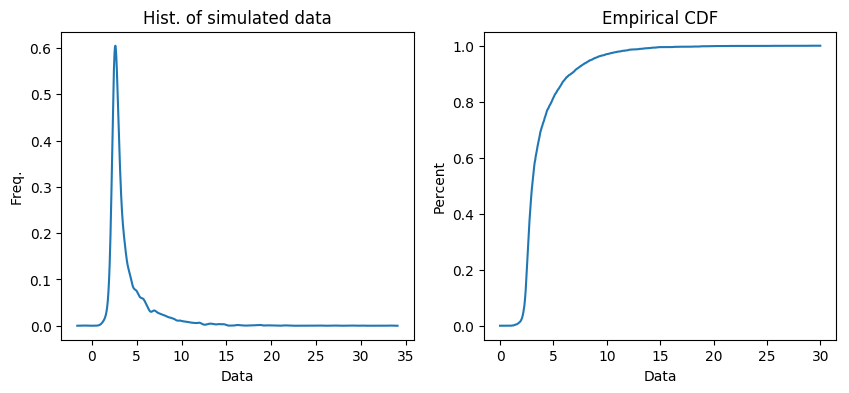

In [32]:
# kernel density for simulated data
h1 = kde(problem.data.y);

# plot simulated data
PyPlot.figure(figsize=(10,4));
subplot(121);
PyPlot.plot(h1.x,h1.density);
PyPlot.ylabel("Freq.");
PyPlot.xlabel("Data");
PyPlot.title("Hist. of simulated data");

# compute empercial CDF
ecdf_func = ecdf(problem.data.y);
x = linspace(0, 30, 1000);

# plot emperical CDF
subplot(122);
PyPlot.plot(x,ecdf_func(x));
PyPlot.ylabel("Percent");
PyPlot.xlabel("Data");
PyPlot.title("Empirical CDF");


Run the ABC rejection sampling algorithm. WARNING: This can take a few minutes to run. 

In [33]:
# run ABC rejection sampling

# fix random numbers 
srand(100);

res = @time abcrejectionsampling(problem, sample_from_prior, generate_data, calc_summary, prior, N, ϵ) 


Starting ABC rejection sampling 
Accuracy: ϵ = 2.500000
Percentage done: 0.00
Percentage done: 2.00
Percentage done: 4.00
Percentage done: 6.00
Percentage done: 8.00
Percentage done: 10.00
Percentage done: 12.00
Percentage done: 14.00
Percentage done: 16.00
Percentage done: 18.00
Percentage done: 20.00
Percentage done: 22.00
Percentage done: 24.00
Percentage done: 26.00
Percentage done: 28.00
Percentage done: 30.00
Percentage done: 32.00
Percentage done: 34.00
Percentage done: 36.00
Percentage done: 38.00
Percentage done: 40.00
Percentage done: 42.00
Percentage done: 44.00
Percentage done: 46.00
Percentage done: 48.00
Percentage done: 50.00
Percentage done: 52.00
Percentage done: 54.00
Percentage done: 56.00
Percentage done: 58.00
Percentage done: 60.00
Percentage done: 62.00
Percentage done: 64.00
Percentage done: 66.00
Percentage done: 68.00
Percentage done: 70.00
Percentage done: 72.00
Percentage done: 74.00
Percentage done: 76.00
Percentage done: 78.00
Percentage done: 80.00
Percen

([2.84974 2.94921 … 2.53447 2.75429; 0.681838 1.28116 … 1.01928 2.23327; 3.86498 4.79759 … 8.30333 7.63495; 1.2853 0.812489 … 0.62598 0.503674], 0.00178, [3.00715, 37.7178, 27.5114, 58.5651, 154.443, 4.88324, 575.386, 1079.82, 20.2528, 142.42  …  37.9548, 78.2507, 46.2149, 50.5769, 360.353, 377.713, 37.9846, 158.317, 42.8971, 481.848], [2.60125 8.21009 … 8.79719 1.08342; 1.90313 1.62376 … 0.605185 2.4887; 6.60911 4.29838 … 2.7316 1.34658; 0.671932 0.375648 … 0.16352 7.92383], [15.1322 17.2229 … 10.5828 15.6328; 23.4947 25.3245 … 8.92231 -24.5435; … ; 3.22889 8.59126 … 9.8293 0.815958; 6.71508 8.0637 … 8.7209 -62600.5])

Set values for approximate posterior distribution.

In [34]:
approx_posterior_samples = res[1]

4×89 Array{Float64,2}:
 2.84974   2.94921   2.80699  3.2394    …  3.0402    2.53447  2.75429 
 0.681838  1.28116   1.5441   3.25771      1.35707   1.01928  2.23327 
 3.86498   4.79759   4.18922  3.57153      4.25702   8.30333  7.63495 
 1.2853    0.812489  1.25101  0.198029     0.290269  0.62598  0.503674

Parameter estimations (posterior mean).

In [36]:
# calc posterior mean 
post_mean_abcrs = mean(approx_posterior_samples,2)

# create data frame 
df_abcrs_param_est = DataFrame(parameter = ["A"; "B";"g";"k"], true_values = problem.model_param.theta_true, post_mean = round.(post_mean_abcrs[:],3))

,parameter,true_values,post_mean
1,A,3.0,2.952
2,B,1.0,1.194
3,g,2.0,5.281
4,k,0.5,0.647


Parameter estimation uncertenty (posterior quantile interval, 2.5th and 97.5th quantile).

In [62]:
# calc quantiles 
q_abcrs = round.([quantile(approx_posterior_samples[1,:], [0.025 0.975])
            quantile(approx_posterior_samples[2,:], [0.025 0.975])
            quantile(approx_posterior_samples[3,:], [0.025 0.975])
            quantile(approx_posterior_samples[4,:], [0.025 0.975])],3)

# create data frame 
df_abcrs_param_est_unc = DataFrame(parameter = ["A"; "B";"g";"k"], true_values = problem.model_param.theta_true, quant_int =   ["($(q_abcrs[1,1]), $(q_abcrs[1,2]))"; "($(q_abcrs[2,1]), $(q_abcrs[2,2]))"; "($(q_abcrs[3,1]), $(q_abcrs[3,2]))";  "($(q_abcrs[4,1]), $(q_abcrs[4,2]))"])

,parameter,true_values,quant_int
1,A,3.0,"(2.535, 3.257)"
2,B,1.0,"(0.1, 2.745)"
3,g,2.0,"(0.382, 9.871)"
4,k,0.5,"(0.013, 1.375)"


Acceptance rate. 

In [38]:
res[2]

0.00178

Plot approximate posterior samples. The accepted samples follow the blue lines, and the true parameter values are indicated with the black lines. 

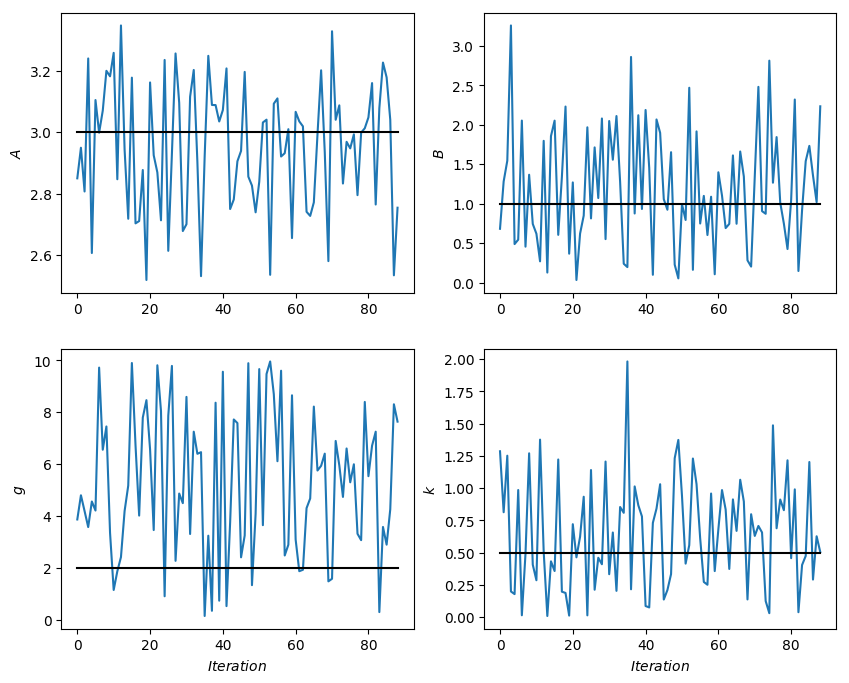

In [40]:
# set prior dist   
prior_parameters = prior.prior_parameters;

# plot posterior samples
PyPlot.figure(figsize=(10,8));
PyPlot.subplot(221);
PyPlot.plot(approx_posterior_samples[1,:]);
PyPlot.plot(ones(size(approx_posterior_samples,2),1)*problem.model_param.theta_true[1], "k");
PyPlot.ylabel(L"$A$");
PyPlot.subplot(222);
PyPlot.plot(approx_posterior_samples[2,:]);
PyPlot.plot(ones(size(approx_posterior_samples,2),1)*problem.model_param.theta_true[2], "k");
PyPlot.ylabel(L"$B$");
PyPlot.subplot(223);
PyPlot.plot(approx_posterior_samples[3,:]);
PyPlot.plot(ones(size(approx_posterior_samples,2),1)*problem.model_param.theta_true[3], "k");
PyPlot.ylabel(L"$g$");
PyPlot.xlabel(L"Iteration");
PyPlot.subplot(224);
PyPlot.plot(approx_posterior_samples[4,:]);
PyPlot.plot(ones(size(approx_posterior_samples,2),1)*problem.model_param.theta_true[4], "k");
PyPlot.xlabel(L"Iteration");
PyPlot.ylabel(L"$k$");

Plot approximate posterior distribution. The approximate marginal posteriors follow blue lines, the uniform prior distributions follow the green linea, and the true parameter values are indicated with the black vertical lines. 

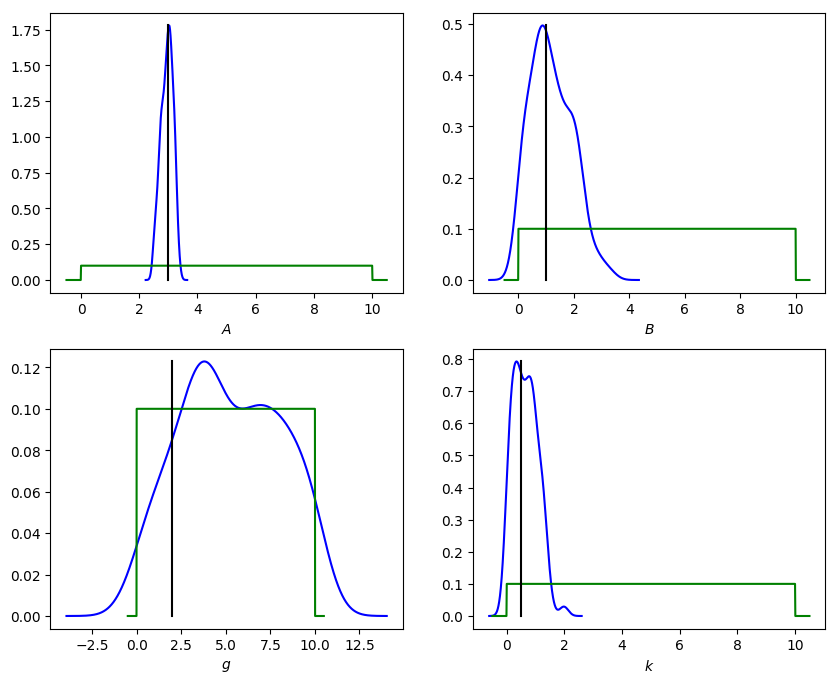

In [42]:

# plot approx. posterior dist

# calc grid for prior dist
x_c1 = prior_parameters[1,1]-0.5:0.01:prior_parameters[1,2]+0.5;
x_c2 = prior_parameters[2,1]-0.5:0.01:prior_parameters[2,2]+0.5;
x_c3 = prior_parameters[3,1]-0.5:0.01:prior_parameters[3,2]+0.5;
x_c4 = prior_parameters[4,1]-0.5:0.01:prior_parameters[4,2]+0.5;

# calc prior dist
priordens_c1 = pdf.(Uniform(prior_parameters[1,1], prior_parameters[1,2]), x_c1);
priordens_c2 = pdf.(Uniform(prior_parameters[2,1], prior_parameters[2,2]), x_c2);
priordens_c3 = pdf.(Uniform(prior_parameters[3,1], prior_parameters[3,2]), x_c3);
priordens_c4 = pdf.(Uniform(prior_parameters[4,1], prior_parameters[4,2]), x_c4);

# calc kernel density approx. for approx. posterior 
h1 = kde(approx_posterior_samples[1,:]);
h2 = kde(approx_posterior_samples[2,:]);
h3 = kde(approx_posterior_samples[3,:]);
h4 = kde(approx_posterior_samples[4,:]);

      
PyPlot.figure(figsize=(10,8));
subplot(221);
PyPlot.plot(h1.x,h1.density, "b");
PyPlot.plot(x_c1,priordens_c1, "g");
PyPlot.plot((problem.model_param.theta_true[1], problem.model_param.theta_true[1]), (0, maximum(h1.density)), "k");
PyPlot.xlabel(L"$A$");
subplot(222);
PyPlot.plot(h2.x,h2.density, "b");
PyPlot.plot(x_c2,priordens_c2, "g");
PyPlot.plot((problem.model_param.theta_true[2], problem.model_param.theta_true[2]), (0, maximum(h2.density)), "k");
PyPlot.xlabel(L"$B$");
subplot(223);
PyPlot.plot(h3.x,h3.density, "b");
PyPlot.plot(x_c3,priordens_c3, "g");
PyPlot.plot((problem.model_param.theta_true[3], problem.model_param.theta_true[3]), (0, maximum(h3.density)), "k");
PyPlot.xlabel(L"$g$");
subplot(224);
PyPlot.plot(h4.x,h4.density, "b");
PyPlot.plot(x_c4,priordens_c4, "g");
PyPlot.plot((problem.model_param.theta_true[4], problem.model_param.theta_true[4]), (0, maximum(h4.density)), "k");
PyPlot.xlabel(L"$k$");

We see that we can estimate all parameters except $g$. 

## ABC-MCMC <a name="subsecabc1"></a>

The ABC-MCMC algorithm is an MCMC type algorithm where the likelihood ratio of the standard MH algorithm is replaced with an indicator function that determines if the distance between the summary statistics for the proposal $S(y^{\star})$ and the data $S(y)$ is sufficiently small (see [ [7]](#ref_12), and [ [12]](#ref_14) for a more detailed introduction to the algorithm). The pseudo-code for the algorithm is 

At iteration t: 
1. Generate $\theta^{\star} \sim p(\theta)$.
2. Generate data set $y^{\star}$ from the model using $\theta^{\star}$. 
3. Compute summery statistics $s^{\star} = S(y^{\star})$
4. Compute  $\alpha = \min\big(1, \frac{\pi(\theta^{\star})}{\pi(\theta^{i-1})}\frac{q(\theta^{i-1} \mid \theta^{\star})}{q(\theta^{\star}  \mid \theta^{r-1})} \mathbb{1}(\rho(s,s^{\star},w) < \epsilon^{i-1})\big)$.
5. Draw $u \sim \mathcal{U}(0,1)$.
6. If $u \leq \alpha$ accepte the proposal, and add it tothe chain, else reject the proposal, and keep the old $\theta^{i-1}$.

The sequence $\epsilon^{i-1}$ is a sequence of bandwidths. In practice is this sequence a decreasing sequence of bandwidths allowing us to both explore the parameter space at the beginning of the algorithm and also obtaining a good approximation of the posterior distribution.  

#### The code for the ABC-MCMC algorithm 

Since we already loaded all functions for an ABC type algorithm, we only have to load the ABC-MCMC function and its help function.

In [43]:

doc"""
    abcmcmc(problem::ProblemABCMCMC, sample_from_prior, evaluate_prior, generate_data, calc_summary)

The ABC-MCMC algorithm.
"""
function abcmcmc(problem::ProblemABCMCMC, sample_from_prior, evaluate_prior, generate_data, calc_summary)

  # data
  y = problem.data.y
  y_star = copy(y)
  N = length(y) # length of data set

  # algorithm parameters
  R = problem.alg_param.R # number of iterations
  burn_in = problem.alg_param.burn_in # burn in
  print_interval = problem.alg_param.print_interval # print accaptance rate and covarince function ever print_interval:th iteration
  start = problem.alg_param.start

  # model parameters
  theta_true = problem.model_param.theta_true # [log(r) log(phi) log(sigma)]
  theta_known = problem.model_param.theta_known # NaN
  theta_0 = problem.model_param.theta_0 # [log(r_0) log(phi_0) log(sigma_0)]

  # ABC parameters
  nbr_summary_stats = problem.alg_param.nbr_summary_stats
  s = zeros(nbr_summary_stats)
  s_star = zeros(nbr_summary_stats)
  eps = problem.alg_param.eps
  w =  problem.alg_param.w
  s_matrix = zeros(length(s_star), R)

  # pre-allocate matricies and vectors
  Theta = zeros(length(theta_0),R)
  loglik = zeros(R)
  accept_vec = zeros(R)
  prior_vec = zeros(R)
  theta_star = zeros(length(theta_0))
  a_log = 0.

  # training data
  X = zeros(length(theta_0),R)
  Y = zeros(R)

  # parameters for adaptive update
  adaptive_update_params = set_adaptive_alg_params(problem.adaptive_update, length(theta_0),Theta[:,1], R)

  # parameters for prior dist
  dist_type = problem.prior_dist.dist
  prior_parameters = problem.prior_dist.prior_parameters

  # print information at start of algorithm
  @printf "Starting ABC-MCMC estimating %d parameters\n" length(theta_true)
  @printf "Adaptation algorithm: %s\n" typeof(problem.adaptive_update)
  @printf "Prior distribution: %s\n" problem.prior_dist.dist

  # first iteration
  @printf "Iteration: %d\n" 1
  @printf "Covariance:\n"
  print_covariance(problem.adaptive_update,adaptive_update_params, 1)

  s = calc_summary(y)

  # initial iteration
  if start == "random"
    while true
      theta_star = sample_from_prior(problem.prior_dist)
      y_star = generate_data(N, theta_star,theta_known)
      s_star = calc_summary(y_star)
      if ρ(s,s_star,w) < eps[1]
        break
      end
    end
  else
    theta_star = theta_0
  end

  dist_vec = zeros(R)
  ind_vec = zeros(R)
  Theta[:,1] = theta_star
  accept_vec[1] = 1

  @printf "Start value:\n"
  show(theta_star)

  X[:,1] = theta_star
  Y[1] = 1

  s_matrix[:,1] = calc_summary(y_star)

  for r = 2:R

    # set print_on to false, only print each print_interval:th iteration
    print_on = false

    # print acceptance rate for the last print_interval iterations
    if mod(r-1,print_interval) == 0
      print_on = true # print ESS and Nbr resample each print_interval:th iteration
      # print progress
      @printf "Percentage done: %.2f\n" 100*(r-1)/R
      # print accaptace rate
      @printf "Acceptance rate on iteration %d to %d is %.4f\n" r-print_interval r-1  sum(accept_vec[r-print_interval:r-1])/( r-1 - (r-print_interval) )
      # print covaraince function
      @printf "Covariance:\n"
      print_covariance(problem.adaptive_update,adaptive_update_params, r)
    end

    # Gaussian random walk
    (theta_star, ) = gaussian_random_walk(problem.adaptive_update, adaptive_update_params, Theta[:,r-1], r)

    # store theta_star
    X[:,r] = theta_star


    # compute accaptance probability
    if dist_type == "Uniform" # uniform priors
      prior_log_star = evaluate_prior(theta_star,prior_parameters)
      if prior_log_star == -Inf # reject if the proposed theta is outside the prior
        prior_vec[r] = 1
        accept = false
        Y[r] = 0 # store prob val
      else
        # Generate data
        y_star = generate_data(N, theta_star, theta_known)

        # Compute summary stats
        s_star = calc_summary(y_star)
        s_matrix[:,r] = s_star

        a = indicator(s , s_star, w, eps[r])
        a_log = log(a)
        accept =  a == 1
        Y[r] = a # store prob val
      end
    end

    # update chain
    if accept # the proposal is accapted
      Theta[:,r] = theta_star # update chain with new proposals
      accept_vec[r] = 1
    else
      dist_vec[r] = dist_vec[r-1]
      ind_vec[r] = ind_vec[r-1]
      Theta[:,r] = Theta[:,r-1] # keep old values
    end

    # adaptation of covaraince matrix for the proposal distribution
    adaptation(problem.adaptive_update, adaptive_update_params, Theta, r,a_log)

  end

  @printf "Ending ABC-MCMC with adaptive RW estimating %d parameters\n" length(theta_true)
  @printf "Adaptation algorithm: %s\n" typeof(problem.adaptive_update)
  @printf "Prior distribution: %s\n" problem.prior_dist.dist

  cov_prop_kernel = get_covariance(problem.adaptive_update,adaptive_update_params, R)

  return return_results(Theta,accept_vec,prior_vec, problem,adaptive_update_params),X,Y, cov_prop_kernel, s_matrix

end

abcmcmc

The indicator function.  

In [44]:
doc"""
    indicator(s::Vector, s_star::Vector, w::Vector, eps::Float64)

Indicator function for the ABC-MCMC updating step.
"""
function indicator(s::Vector, s_star::Vector, w::Vector, eps::Float64)

  if ρ(s,s_star,w) < eps
    return 1.
  else
    return 0.
  end

end

indicator

Function to return the results. 

In [45]:

doc"""
    return_results(Theta,loglik,accept_vec,prior_vec, problem,adaptive_update_params)

Constructs the return type of the resutls from the MCWH and PMCMC algorithm.
"""
function return_results(Theta,accept_vec,prior_vec, problem,adaptive_update_params)

  if typeof(problem.adaptive_update) == AMUpdate_gen
    return (Result(Theta, loglik, accept_vec, prior_vec), adaptive_update_params[6])
  else
    return Result(Theta, accept_vec, prior_vec)
  end

end

return_results

### Case study - g-and.k distribution, again <a name="subsubsecabc2_case"></a>

We will now again consider the g-and-k distribution, but we now use the ABC-MCMC algorithm to compute the inference.

Function to set up the ABC-MCMC problem for the g-and-k distribution. 

In [46]:

doc"""
    set_up_abcmcmc_problem_gk(use_sim_data::Bool=true;nbr_of_unknown_parameters::Int64=2,
  prior_dist::String = "Uniform", adaptiveon::Bool = true, ploton::Bool = false,
  nbr_of_cores::Int64 = 8, T::Int64 = 10000,x0::Float64 = 7.,
  print_interval::Int64 = 500, alg::String="abcmcmc", nbr_summary_stats::Int64=5,
  start::String = "random")

set_up_abcmcmc_problem sets the parameters for the problem defined by the inputs.

# Output
* `problem`: An instance of the type ProblemABCMCMC cointaining all information for the problem
"""
function set_up_abcmcmc_problem_gk(use_sim_data::Bool=true;nbr_of_unknown_parameters::Int64=2,
  prior_dist::String = "Uniform", adaptiveon::Bool = true, ploton::Bool = false,
  nbr_of_cores::Int64 = 8, T::Int64 = 5000,x0::Float64 = 7.,
  print_interval::Int64 = 500, alg::String="abcmcmc", nbr_summary_stats::Int64=5,
  start::String = "random")


  # set algorithm parameters
  theta_true = [3; 1; 2; .5]  # [A,B,g,k]
  theta_0 =  copy(theta_true)  # start at true values

  if start == "non-random"
    theta_0 = [2;2;2;2]
  end

  prior_parameters = [0 10; 0 10; 0 10; 0 10]
  theta_known = .8 # c

  eps = [30*ones(5000); 25*ones(5000); 20*ones(5000); 15*ones(5000); 10*ones(5000); 5*ones(5000); 2.5*ones(5000); 1*ones(5000); 0.3*ones(5000); 0.2*ones(50000)] # ; 0.05*ones(100000)

  # create instance of AlgorithmParametersABCMCMC (set parameters to default values)
  alg_param = AlgorithmParametersABCMCMC(length(eps),length(eps)-35000,alg,print_interval,nbr_summary_stats,eps,start,ones(5)) # hardcoded nbr of summary stats

  # create instance of ModelParameters, all theta paramters are on log-scale
  model_param = ModelParameters(theta_true,theta_known,theta_0)

  # set data
  if use_sim_data
    y = generate_data_gk(T, theta_true[1], theta_true[2], theta_true[3], theta_true[4], theta_known)
  end

  # create instance of Data
  data = Data(y)

  # create instance of PriorDistribution
  prior = PriorDistribution(prior_dist, prior_parameters)

  # create instance of AdaptiveUpdate
  adaptive_update = AMUpdate(eye(length(theta_0)), 2.4/sqrt(length(theta_0)), 1., 0.7, 50)

  # return the an instance of Problem
  return ProblemABCMCMC(data, alg_param, model_param, adaptive_update, prior)

end


set_up_abcmcmc_problem_gk

Function to evaluate the prior. 

In [47]:
function  evaluate_prior(theta_star::Vector, prior_parameters::Matrix, dist_type::String = "Uniform")

  # set start value for loglik
  log_likelihood = 0.

  if dist_type == "Uniform"
    for i = 1:length(theta_star)
      # Update loglik, i.e. add the loglik for each model paramter in theta
      log_likelihood = log_likelihood + log_unifpdf( theta_star[i], prior_parameters[i,1], prior_parameters[i,2] )
    end
  else
    # add other priors
  end

  return log_likelihood # return log_lik

end

# help function 

doc"""
    log_unifpdf(x::Float64, a::Float64,b::Float64)

Computes log(unifpdf(x,a,b)).
"""
function log_unifpdf(x::Float64, a::Float64, b::Float64)

  if  x >= a && x<= b
    return -log(b-a);
  else
    return log(0);
  end

end



log_unifpdf

Since we already specified the functions `sample_from_prior`, `evaluate_prior`, `generate_data`, and `calc_summary` for the g-and-k distribution we can now directly set the problem. Here we set the sequence of $\epsilon$'s to start at a large value, and this value is then decreased at every 5000:th iteration until we reach the $\epsilon$ value that we want to use when collecting the values for the approximate posterior, in this case, $\epsilon = 0.2$. We also use an adaptive random walk proposal now. 

In [48]:
problem = set_up_abcmcmc_problem_gk(ploton = true,
  start = "non-random", print_interval=10000)

# load data 
problem.data.y = Array(readtable("data/gandk_data.csv"))[:]


# set weigths
problem.alg_param.w  =  [0.22; 0.19; 0.53; 2.97; 1.90]
  
# run @eps=0.2
problem.alg_param.eps = [30*ones(5000); 25*ones(5000); 20*ones(5000); 15*ones(5000); 10*ones(5000); 5*ones(5000); 2.5*ones(5000); 1*ones(5000); 0.3*ones(5000); 0.2*ones(110000)] 


problem.alg_param.burn_in = length(problem.alg_param.eps)-100000
problem.alg_param.R = length(problem.alg_param.eps)

155000

Run the ABC-MCMC algorithm. WARNING: This can take a few minutes to run.  

In [49]:
# fix random numbers 
srand(100);

res, X, Y, cov_prop_kernel = @time abcmcmc(problem, sample_from_prior, evaluate_prior, generate_data, calc_summary);

Starting ABC-MCMC estimating 4 parameters
Adaptation algorithm: AMUpdate
Prior distribution: Uniform
Iteration: 1
Covariance:
[1.44 0.0 0.0 0.0; 0.0 1.44 0.0 0.0; 0.0 0.0 1.44 0.0; 0.0 0.0 0.0 1.44]
Start value:
[2.0, 2.0, 2.0, 2.0]Percentage done: 6.45
Acceptance rate on iteration 1 to 10000 is 0.2772
Covariance:
[4.64383 2.54532 -1.05876 -0.603952; 2.54532 10.6651 -1.03293 -2.135; -1.05876 -1.03293 10.2746 1.0772; -0.603952 -2.135 1.0772 1.93813]
Percentage done: 12.90
Acceptance rate on iteration 10001 to 20000 is 0.2287
Covariance:
[1.58337 0.469374 -1.13492 -0.0321736; 0.469374 9.62357 1.16766 -1.02671; -1.13492 1.16766 11.6804 0.0652556; -0.0321736 -1.02671 0.0652556 0.866143]
Percentage done: 19.35
Acceptance rate on iteration 20001 to 30000 is 0.2137
Covariance:
[0.269073 0.391931 -0.449191 -0.0412186; 0.391931 2.54416 0.60083 -0.508648; -0.449191 0.60083 10.1543 -0.328186; -0.0412186 -0.508648 -0.328186 0.56277]
Percentage done: 25.81
Acceptance rate on iteration 30001 to 4000

Set values for obtained results.

In [50]:
Theta = res.Theta_est;
accept_vec = res.accept_vec;
prior_vec = res.prior_vec;
burn_in = problem.alg_param.burn_in;
prior_parameters = problem.prior_dist.prior_parameters;
theta_true = problem.model_param.theta_true;


Estimated parameters (posterior mean).

In [67]:
# calc posterior mean 
post_mean_abcmcmc = mean(Theta[:,burn_in+1:end],2)

# create data frame 
df_abcmcmc_param_est = DataFrame(parameter = ["A"; "B";"g";"k"], true_values = problem.model_param.theta_true, post_mean = round.(post_mean_abcmcmc[:],3))

,parameter,true_values,post_mean
1,A,3.0,3.011
2,B,1.0,0.996
3,g,2.0,2.121
4,k,0.5,0.594


Parameter estimation uncertenty (posterior quantile interval, 2.5th and 97.5th quantile).

In [68]:
# calc posterior quantiles 
q_abcmcmc = round.([quantile(Theta[1,burn_in:end], [0.025 0.975])
    quantile(Theta[2,burn_in:end], [0.025 0.975])
    quantile(Theta[3,burn_in:end], [0.025 0.975])
    quantile(Theta[4,burn_in:end], [0.025 0.975])],3)

# create data frame 
df_mh_param_est_unc = DataFrame(parameter = ["A"; "B";"g";"k"], true_values = problem.model_param.theta_true, quant_int =   ["($(q_abcmcmc[1,1]), $(q_abcmcmc[1,2]))"; "($(q_abcmcmc[2,1]), $(q_abcmcmc[2,2]))"; "($(q_abcmcmc[3,1]), $(q_abcmcmc[3,2]))";  "($(q_abcmcmc[4,1]), $(q_abcmcmc[4,2]))"])


,parameter,true_values,quant_int
1,A,3.0,"(2.966, 3.058)"
2,B,1.0,"(0.851, 1.145)"
3,g,2.0,"(1.714, 2.55)"
4,k,0.5,"(0.461, 0.738)"


Acceptance rate. 

In [53]:
acceptance_rate = sum(accept_vec[burn_in:end])/length(accept_vec[burn_in:end])

0.11173888261117389

Plot chains. 

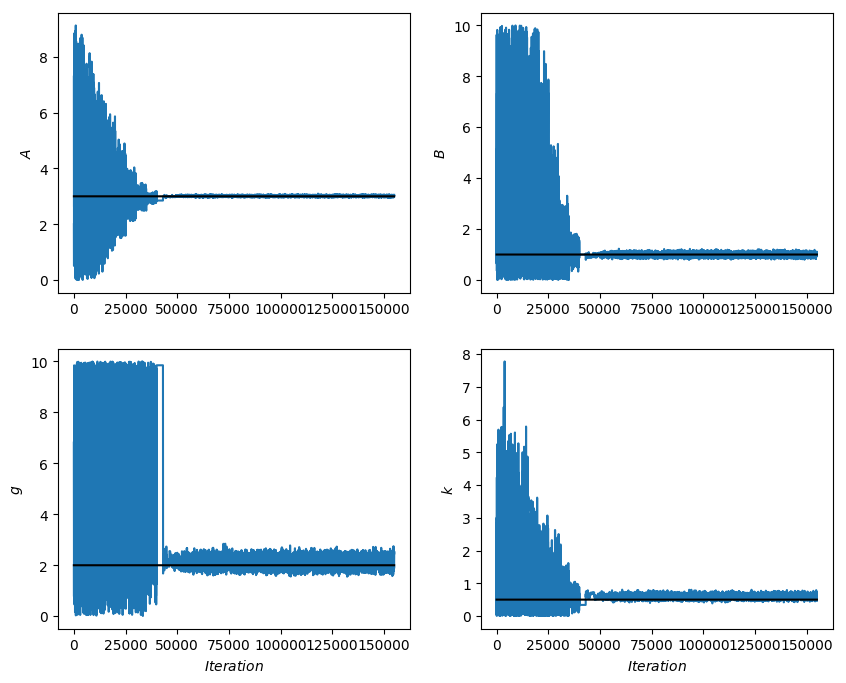

In [54]:
# plot chains
PyPlot.figure(figsize=(10,8));
PyPlot.subplot(221);
PyPlot.plot(Theta[1,:]);
PyPlot.plot(ones(size(Theta,2),1)*problem.model_param.theta_true[1], "k");
PyPlot.ylabel(L"$A$");
PyPlot.subplot(222);
PyPlot.plot(Theta[2,:]);
PyPlot.plot(ones(size(Theta,2),1)*problem.model_param.theta_true[2], "k");
PyPlot.ylabel(L"$B$");
PyPlot.subplot(223);
PyPlot.plot(Theta[3,:]);
PyPlot.plot(ones(size(Theta,2),1)*problem.model_param.theta_true[3], "k");
PyPlot.ylabel(L"$g$");
PyPlot.xlabel(L"Iteration");
PyPlot.subplot(224);
PyPlot.plot(Theta[4,:]);
PyPlot.plot(ones(size(Theta,2),1)*problem.model_param.theta_true[4], "k");
PyPlot.xlabel(L"Iteration");
PyPlot.ylabel(L"$k$");

Plot chains after burn-in.

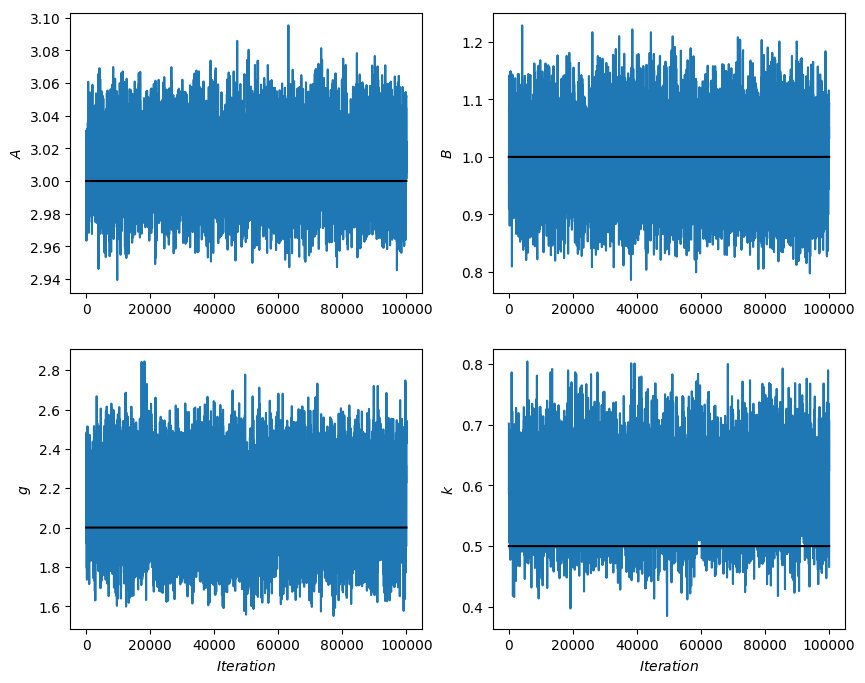

In [55]:
# plot chains after burn in
PyPlot.figure(figsize=(10,8));
PyPlot.subplot(221);
PyPlot.plot(Theta[1,burn_in:end]);
PyPlot.plot(ones(size(Theta[:,burn_in:end],2),1)*problem.model_param.theta_true[1], "k");
PyPlot.ylabel(L"$A$");
PyPlot.subplot(222);
PyPlot.plot(Theta[2,burn_in:end]);
PyPlot.plot(ones(size(Theta[:,burn_in:end],2),1)*problem.model_param.theta_true[2], "k");
PyPlot.ylabel(L"$B$");
PyPlot.subplot(223);
PyPlot.plot(Theta[3,burn_in:end]);
PyPlot.plot(ones(size(Theta[:,burn_in:end],2),1)*problem.model_param.theta_true[3], "k");
PyPlot.ylabel(L"$g$");
PyPlot.xlabel(L"Iteration");
PyPlot.subplot(224);
PyPlot.plot(Theta[4,burn_in:end]);
PyPlot.plot(ones(size(Theta[:,burn_in:end],2),1)*problem.model_param.theta_true[4], "k");
PyPlot.xlabel(L"Iteration");
PyPlot.ylabel(L"$k$");

Plot auto-correlation function for chains. 

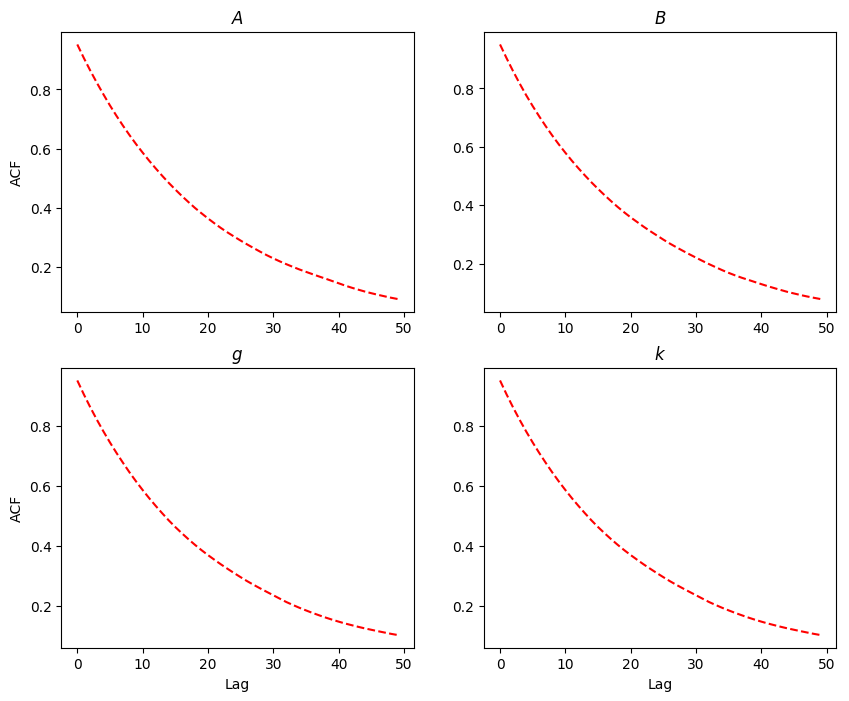

In [56]:
# calc acf
acf_c1 = autocor(Theta[1,burn_in:end],1:50);
acf_c2 = autocor(Theta[2,burn_in:end],1:50);
acf_c3 = autocor(Theta[3,burn_in:end],1:50);
acf_c4 = autocor(Theta[4,burn_in:end],1:50);

# plot acf
PyPlot.figure(figsize=(10,8));
PyPlot.subplot(221);
PyPlot.plot(acf_c1,"--r");
PyPlot.title(L"$A$");
PyPlot.ylabel("ACF");
PyPlot.subplot(222);
PyPlot.plot(acf_c2,"--r");
PyPlot.title(L"$B$");
PyPlot.subplot(223);
PyPlot.plot(acf_c3,"--r");
PyPlot.title(L"$g$");
PyPlot.ylabel("ACF");
PyPlot.xlabel("Lag");
PyPlot.subplot(224);
PyPlot.plot(acf_c3,"--r");
PyPlot.title(L"$k$");
PyPlot.xlabel("Lag");


Plot approximate marginal posteriors.  

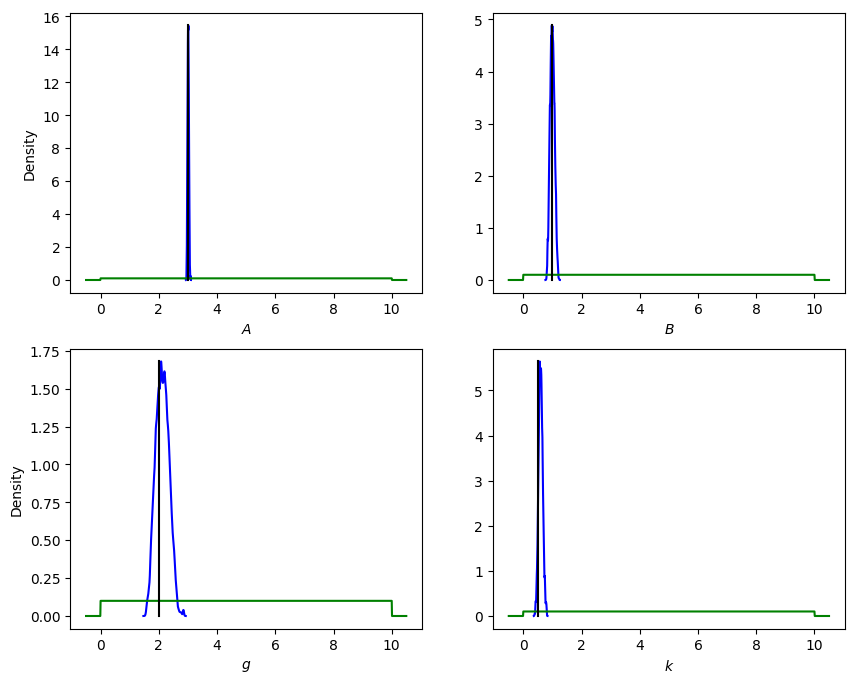

In [57]:

# plot posterior dist

# calc grid for prior dist

x_c1 = prior_parameters[1,1]-0.5:0.01:prior_parameters[1,2]+0.5;
x_c2 = prior_parameters[2,1]-0.5:0.01:prior_parameters[2,2]+0.5;
x_c3 = prior_parameters[3,1]-0.5:0.01:prior_parameters[3,2]+0.5;
x_c4 = prior_parameters[4,1]-0.5:0.01:prior_parameters[4,2]+0.5;

# calc grid for kernel dens est of marginal posterior
x_c1_kerneldens = x_c1;
x_c2_kerneldens = x_c2;
x_c3_kerneldens = x_c3;

# calc prior dist
priordens_c1 = pdf.(Uniform(prior_parameters[1,1], prior_parameters[1,2]), x_c1);
priordens_c2 = pdf.(Uniform(prior_parameters[2,1], prior_parameters[2,2]), x_c2);
priordens_c3 = pdf.(Uniform(prior_parameters[3,1], prior_parameters[3,2]), x_c3);
priordens_c4 = pdf.(Uniform(prior_parameters[4,1], prior_parameters[3,2]), x_c3);


h1 = kde(Theta[1,burn_in:end]);
h2 = kde(Theta[2,burn_in:end]);
h3 = kde(Theta[3,burn_in:end]);
h4 = kde(Theta[4,burn_in:end]);

PyPlot.figure(figsize=(10,8));
subplot(221);
PyPlot.plot(h1.x,h1.density, "b");
PyPlot.plot(x_c1,priordens_c1, "g");
PyPlot.plot((problem.model_param.theta_true[1], problem.model_param.theta_true[1]), (0, maximum(h1.density)), "k");
PyPlot.ylabel("Density");
PyPlot.xlabel(L"$A$");
subplot(222);
PyPlot.plot(h2.x,h2.density, "b");
PyPlot.plot(x_c2,priordens_c2, "g");
PyPlot.plot((problem.model_param.theta_true[2], problem.model_param.theta_true[2]), (0, maximum(h2.density)), "k");
PyPlot.xlabel(L"$B$");
subplot(223);
PyPlot.plot(h3.x,h3.density, "b");
PyPlot.plot(x_c3,priordens_c3, "g");
PyPlot.plot((problem.model_param.theta_true[3], problem.model_param.theta_true[3]), (0, maximum(h3.density)), "k");
PyPlot.ylabel("Density");
PyPlot.xlabel(L"$g$");
subplot(224);
PyPlot.plot(h4.x,h4.density, "b");
PyPlot.plot(x_c4,priordens_c4, "g");
PyPlot.plot((problem.model_param.theta_true[4], problem.model_param.theta_true[4]), (0, maximum(h4.density)), "k");
PyPlot.xlabel(L"$k$");

#### Comparing inference results for ABC-rejection sampling and ABC-MCMC

Posterior for ABC rejection sampling (dashed blue line) and ABC-MCMC (solid blue line). 

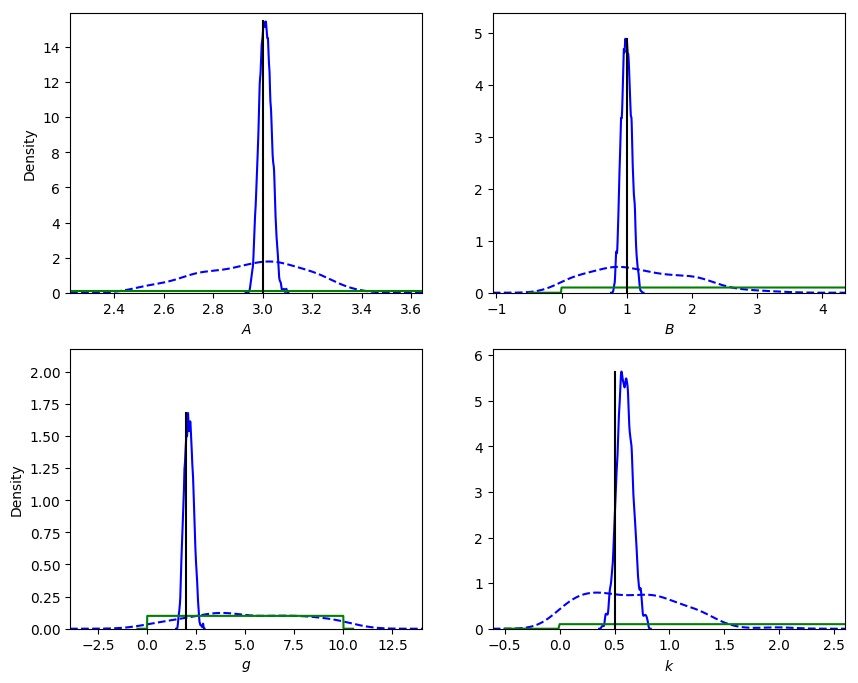

In [58]:
h1_abc_reject = kde(approx_posterior_samples[1,:]);
h2_abc_reject = kde(approx_posterior_samples[2,:]);
h3_abc_reject = kde(approx_posterior_samples[3,:]);
h4_abc_reject = kde(approx_posterior_samples[4,:]);


PyPlot.figure(figsize=(10,8));
subplot(221);
PyPlot.plot(h1_abc_reject.x,h1_abc_reject.density, "b--");
PyPlot.plot(h1.x,h1.density, "b");
PyPlot.plot(x_c1,priordens_c1, "g");
PyPlot.plot((problem.model_param.theta_true[1], problem.model_param.theta_true[1]), (0, maximum(h1.density)), "k");
axis([minimum(h1_abc_reject.x), maximum(h1_abc_reject.x), 0, maximum(h1.density)+0.5]);
PyPlot.ylabel("Density");
PyPlot.xlabel(L"$A$");
subplot(222);
PyPlot.plot(h2_abc_reject.x,h2_abc_reject.density, "b--");
PyPlot.plot(h2.x,h2.density, "b");
PyPlot.plot(x_c2,priordens_c2, "g");
PyPlot.plot((problem.model_param.theta_true[2], problem.model_param.theta_true[2]), (0, maximum(h2.density)), "k");
axis([minimum(h2_abc_reject.x), maximum(h2_abc_reject.x), 0, maximum(h2.density)+0.5]);
PyPlot.xlabel(L"$B$");
subplot(223);
PyPlot.plot(h3_abc_reject.x,h3_abc_reject.density, "b--");
PyPlot.plot(h3.x,h3.density, "b");
PyPlot.plot(x_c3,priordens_c3, "g");
PyPlot.plot((problem.model_param.theta_true[3], problem.model_param.theta_true[3]), (0, maximum(h3.density)), "k");
axis([minimum(h3_abc_reject.x), maximum(h3_abc_reject.x), 0, maximum(h3.density)+0.5]);
PyPlot.ylabel("Density");
PyPlot.xlabel(L"$g$");
subplot(224);
PyPlot.plot(h4_abc_reject.x,h4_abc_reject.density, "b--");
PyPlot.plot(h4.x,h4.density, "b");
PyPlot.plot(x_c4,priordens_c4, "g");
PyPlot.plot((problem.model_param.theta_true[4], problem.model_param.theta_true[4]), (0, maximum(h4.density)), "k");
PyPlot.xlabel(L"$k$");
axis([minimum(h4_abc_reject.x), maximum(h4_abc_reject.x), 0, maximum(h4.density)+0.5]);


Compare parameter estimations obtained from ABC rejection sampling and the ABC MCMC. 

In [69]:
df_param_est = DataFrame(parameter = ["A"; "B";"g"; "k"], true_values = problem.model_param.theta_true, ABC_rs = ["$(df_abcrs_param_est[1,3]) ($(q_abcrs[1,1]), $(q_abcrs[1,2]))"; "$(df_abcrs_param_est[2,3]) ($(q_abcrs[2,1]), $(q_abcrs[2,2]))"; "$(df_abcrs_param_est[3,3]) ($(q_abcrs[3,1]), $(q_abcrs[3,2]))"; "$(df_abcrs_param_est[4,3]) ($(q_abcrs[4,1]), $(q_abcrs[4,2]))"], ABC_MCMC = ["$(df_abcmcmc_param_est[1,3]) ($(q_abcmcmc[1,1]), $(q_abcmcmc[1,2]))"; "$(df_abcmcmc_param_est[2,3]) ($(q_abcmcmc[2,1]), $(q_abcmcmc[2,2]))"; "$(df_abcmcmc_param_est[3,3]) ($(q_abcmcmc[3,1]), $(q_abcmcmc[3,2]))"; "$(df_abcmcmc_param_est[4,3]) ($(q_abcmcmc[4,1]), $(q_abcmcmc[4,2]))"])


,parameter,true_values,ABC_rs,ABC_MCMC
1,A,3.0,"2.952 (2.535, 3.257)","3.011 (2.966, 3.058)"
2,B,1.0,"1.194 (0.1, 2.745)","0.996 (0.851, 1.145)"
3,g,2.0,"5.281 (0.382, 9.871)","2.121 (1.714, 2.55)"
4,k,0.5,"0.647 (0.013, 1.375)","0.594 (0.461, 0.738)"


We can conclude that the parameter estimations computed using the ABC-MCMC algorithm are much better compared to the estimates obtained using the ABC rejection sampling algorithm since the ABC-MCMC algorithm allows us to capture all parameters. The posterior distribution obtained using the ABC-MCMC algorithm is also much more informative compared to the posterior distribution obtained from the ABC rejection sampling algorithm. 

The ABC-MCMC algorithm produces better inference results since the proposal distribution changes during the algorithm and hence allows us to use a smaller $\epsilon$ threshold with still obtaining a reasonable high acceptance rate. For the ABC rejection sampling algorithm is the proposal distribution during the entire algorithm the prior distribution and we, therefore, must use a large $\epsilon$ in order to get any accepted proposal at all. 

## Conclusions  <a name="sec_conclusions"></a>

We have here given a general introduction to the Bayesian inference and in particular an introduction to the Approximative Bayesian Computing method. In particular, we see that the Approximative Bayesian Computing method can be using an MCMC setting, allowing us to construct more efficient algorithms, in comparison to using the rejection sampling scheme and still using a likelihood-free setting.  

## References

1. Allingham, David, R. A. R. King, and Kerrie L. Mengersen. "Bayesian estimation of quantile distributions." Statistics and Computing 19, no. 2 (2009): 189-201. <a name="ref_11"></a>

2. Andrieu, Christophe, and Johannes Thoms. "A tutorial on adaptive MCMC." Statistics and computing 18, no. 4 (2008): 343-373. <a name="ref_5"></a>

3. Drovandie, Christopher C. "Approximate Bayesian Computation." In wiley StatsRef: Statistics References Online. John Wiley & Sons Lt,Ltd. pp 1-9, 2017. <a name="ref_7"></a>

4.  Etz, Alexander, Quentin Frederik Gronau, Fabian Dablander, Peter Edelsbrunner, and Beth Baribault. "How to become a Bayesian in eight easy steps: An annotated reading list." (2016)<a name="ref_1"></a> 

5. Gelman, Andrew, Daniel Simpson, and Michael Betancourt. "The prior can generally only be understood in the context of the likelihood." arXiv preprint arXiv:1708.07487 (2017). <a name="ref_2"></a> 

6. Haario, Heikki, Eero Saksman, and Johanna Tamminen. "An adaptive Metropolis algorithm." Bernoulli 7, no. 2 (2001): 223-242. <a name="ref_4"></a>

7. Marjoram, Paul, John Molitor, Vincent Plagnol, and Simon Tavaré. "Markov chain Monte Carlo without likelihoods." Proceedings of the National Academy of Sciences 100, no. 26 (2003): 15324-15328. <a name="ref_12"></a>

8. Mueller, Christian Lorenz. "Exploring the common concepts of adaptive MCMC and Covariance Matrix Adaptation schemes." In Dagstuhl Seminar Proceedings. Schloss Dagstuhl-Leibniz-Zentrum fÃ¼r Informatik, 2010. <a name="ref_6"></a>

9. Picchini, Umberto, and Rachele Anderson. "Approximate maximum likelihood estimation using data-cloning ABC." Computational Statistics & Data Analysis 105 (2017): 166-183.. <a name="ref_10"></a>

10. Prangle, Dennis. "Summary statistics in approximate Bayesian computation." arXiv preprint arXiv:1512.05633 (2015). <a name="ref_8"></a>

11. Prangle, Dennis. "Adapting the ABC distance function." Bayesian Analysis 12.1 (2017): 289-309. <a name="ref_9"></a>

12. Scott A. Sisson, Yanan Fan. "Likelihood-free Markov chain Monte Carlo." arXiv preprint arXiv:1001.2058v1 (2010). <a name="ref_13"></a>

13. Yildirim, Ilker. "Bayesian Inference: Metropolis-Hastings Sampling." Dept. of Brain and Cognitive Sciences, Univ. of Rochester, Rochester, NY (2012). <a name="ref_3"></a>
